# MIA attacks on Length-of-Stay predictor, Gated Recurrent Unit with Decay (GRU-D), with DPSGD
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables
conda install -c conda-forge opacus

In [1]:
import os
import sys

from torch import zeros

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from utils.data_processing import get_mimic_dataloaders, get_mimic_dataset

/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")

train_frac = 0.4
valid_frac = 0.0
test_frac = 0.0
early_stop_frac = 0.4
batch_size = 74
use_LR = False # True if you want to use the LR model, False if you want to use the GRUD model

dataset, train_indices, validation_indices, test_indices, early_stop_indices= get_mimic_dataset(path,
                                                                            train_frac ,
                                                                            valid_frac,
                                                                            test_frac,
                                                                            early_stop_frac,
                                                                            use_LR)

Loading dataset...
Loaded dataset from /home/fazeleh/LeakPro/examples/mia/LOS/data/GRUD_data/dataset.pkl


In [3]:
train_loader, validation_loader, test_loader, early_stop_loader = get_mimic_dataloaders(dataset,
                                                            train_indices,
                                                            validation_indices,
                                                            test_indices,
                                                            early_stop_indices,
                                                            batch_size)

In [4]:
target_model_dir = "./target_GRUD_dpsgd"
epsilons = [.0001, .001, .01, .1, .5, 1, 2, 3.5, 5, 7, 10] # epsilons to run over
delta = 1e-5
target_epsilon = 3.5
sample_rate = 1/len(train_loader) # already incorporates batchsize

In [5]:
noise_multiplier_dict = {
    "target_epsilon": target_epsilon,
    "target_delta": delta,
    "sample_rate": sample_rate,
    "epochs": 21,
    "epsilon_tolerance": 0.01,
    "accountant": "prv",
    "eps_error": 0.01,
    "max_grad_norm": 1,
}


In [6]:
optimized_hyperparams ={
    "hidden_size": 27,
    "learning_rate": 0.000289,
    "num_epochs":2,
    "patience_early_stopping": 40,
    "patience_lr_scheduler": 2,
    "batch_size": 74,
    "seed": 6286,
    "min_delta": 0.00001,
    }

n_features = int(dataset.x.shape[1]/3)
X_mean = zeros(1,dataset.x.shape[2],n_features)

# Add other required parameters to model_params
model_params = {
    "hidden_size": optimized_hyperparams["hidden_size"],
    "batch_size": optimized_hyperparams["batch_size"],
    "input_size": n_features,
    "X_mean": X_mean,
    "output_last": False,
    "bn_flag": False,
}

In [7]:
from utils.model_GRUD_dpsgd import *


# Initialize the model with filtered parameters
model = GRUD_DPSGD(**model_params)
# Train the model
results= dpsgd_gru_trained_model_and_metadata(
                                            model,
                                            train_loader,
                                            early_stop_loader,
                                            noise_multiplier_dict,
                                            epochs=optimized_hyperparams["num_epochs"],
                                            patience_early_stopping = optimized_hyperparams["patience_early_stopping"],
                                            patience_lr= optimized_hyperparams["patience_lr_scheduler"],
                                            min_delta = optimized_hyperparams["min_delta"],
                                            learning_rate = optimized_hyperparams["learning_rate"],
                                            target_model_dir = target_model_dir,)
train_losses, test_losses , train_acc, test_acc, best_model, privacy_engine  = results

Model Structure:  GRUD_DPSGD(
  (zl): Linear(in_features=235, out_features=27, bias=True)
  (rl): Linear(in_features=235, out_features=27, bias=True)
  (hl): Linear(in_features=235, out_features=27, bias=True)
  (gamma_x_l): FilterLinear(in_features=104, out_features=104, bias=True)
  (gamma_h_l): Linear(in_features=104, out_features=27, bias=True)
  (fc): Linear(in_features=27, out_features=1, bias=True)
  (drop): Dropout(p=0.57, inplace=False)
)
Start Training ... 
Output type dermined by the model


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
Training Progress:   0%|          | 0/2 [00:00<?, ?it/s]/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_ho

Epoch 0: Validation loss improved to 0.6620
Learning Rate: 0.000289000000
Epoch: 0, train_loss: 0.68064388, valid_loss: 0.66196918


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress: 100%|██████████| 2/2 [00:21<00:00, 10.73s/it]

Epoch 1: Validation loss improved to 0.6480
Learning Rate: 0.000289000000
Epoch: 1, train_loss: 0.65931774, valid_loss: 0.64799779


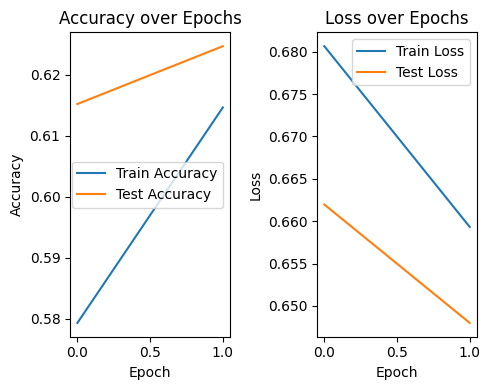

In [8]:
import matplotlib.pyplot as plt

# Convert losses to numpy-compatible lists directly
train_losses_cpu = [float(loss) for loss in train_losses]
test_losses_cpu = [float(loss) for loss in test_losses]

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# from mimic_GRUD_handler import MimicInputHandlerGRU
from mimic_GRUD_dpsgd_handler import MimicInputHandlerGRUdpsgd

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandlerGRUdpsgd, config_path)

# Run the audit
mia_results = leakpro.run_audit(return_results=True)

2025-03-03 14:58:32,253 INFO     Target model blueprint created from GRUD_DPSGD in utils/model_GRUD_dpsgd.py.
03/03/2025 14:58:32:INFO:Target model blueprint created from GRUD_DPSGD in utils/model_GRUD_dpsgd.py.
2025-03-03 14:58:32,262 INFO     Loaded target model metadata from ./target_GRUD_dpsgd/model_metadata.pkl
03/03/2025 14:58:32:INFO:Loaded target model metadata from ./target_GRUD_dpsgd/model_metadata.pkl
/home/fazeleh/LeakPro/leakpro/input_handler/mia_handler.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will

Training shadow models with DP-SGD
Pickle file loaded successfully!
Data: {'target_epsilon': 3.5, 'target_delta': 1e-05, 'sample_rate': 0.007692307692307693, 'epochs': 21, 'epsilon_tolerance': 0.01, 'accountant': 'prv', 'eps_error': 0.01, 'max_grad_norm': 1}


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
Training Progress:   0%|          | 0/2 [00:00<?, ?it/s]/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  50%|█████     | 1/2 [00:10<00:10, 10.21s/it]/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/mod

Training shadow models with DP-SGD
Pickle file loaded successfully!
Data: {'target_epsilon': 3.5, 'target_delta': 1e-05, 'sample_rate': 0.007692307692307693, 'epochs': 21, 'epsilon_tolerance': 0.01, 'accountant': 'prv', 'eps_error': 0.01, 'max_grad_norm': 1}


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
Training Progress:   0%|          | 0/2 [00:00<?, ?it/s]/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  50%|█████     | 1/2 [00:10<00:10, 10.21s/it]/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/mod

In [11]:
# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

# Create the report by compiling the latex text
report_handler.create_report()

03/03/2025 15:01:17:INFO:Initializing report handler...
03/03/2025 15:01:17:INFO:report_dir set to: ./leakpro_output/results
03/03/2025 15:01:17:INFO:Saving results for rmia
03/03/2025 15:01:28:INFO:No results of type GIAResults found.
03/03/2025 15:01:28:INFO:No results of type SinglingOutResults found.
03/03/2025 15:01:28:INFO:No results of type InferenceResults found.
03/03/2025 15:01:28:INFO:No results of type LinkabilityResults found.
03/03/2025 15:01:33:INFO:PDF compiled


<Figure size 640x480 with 0 Axes>